In [ ]:
api_key = {"username":"edfearay11","key":"32ee59b212abf35f56e9ad705548ad46"}

In [ ]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
!pip install kagglehub

import kagglehub

# Descargar el dataset
path = kagglehub.dataset_download("m41k12/imagenes-lima-metropolitana")

print("Dataset descargado en:", path)


100%|██████████| 1.20G/1.20G [00:43<00:00, 29.4MB/s]

Extracting files...


Dataset descargado en: /root/.cache/kagglehub/datasets/m41k12/imagenes-lima-metropolitana/versions/6


# Carga de datos

Una vez loggeados en Kaggle, podemos extraer las features con sus respectivos labels.

In [ ]:
import os
import pandas as pd
import numpy as np

csv_file = os.path.join(path, "y_labels_g.csv")
df = pd.read_csv(csv_file)

print("Contenido del CSV (primeras filas):")
display(df.head())

npy_file = os.path.join(path, "X_features_g.npy")
X = np.load(npy_file)

print("\nShape de X_features.npy:", X.shape)
print("\nPrimeros elementos:")
print(X[:5])

y = df['label']

Contenido del CSV (primeras filas):


,image_path,label,category
0,images\Alto\Alto_La Molina_01_20251118_210128_...,0,Alto
1,images\Alto\Alto_La Molina_02_20251118_210130_...,0,Alto
2,images\Alto\Alto_La Molina_03_20251118_210132_...,0,Alto
3,images\Alto\Alto_La Molina_04_20251118_210136_...,0,Alto
4,images\Alto\Alto_La Molina_05_20251118_210137_...,0,Alto



Shape de X_features.npy: (15097, 1536)

Primeros elementos:
[[-0.6172663   3.1654274   3.9392216  ...  1.2134156   0.6764343
   2.459275  ]
 [-1.3210168  -0.5339875   2.2928514  ...  0.9312533   1.1108109
   2.294093  ]
 [ 0.7945741   0.47068816  0.6571222  ...  0.3529264  -0.7313323
   1.4319109 ]
 [-0.12607546  0.5020312   1.8343413  ... -0.30577734 -0.64622384
   0.04155932]
 [ 0.794605   -0.18930544  0.5696778  ... -0.19862188  0.44221246
   0.8670788 ]]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch


Adecuamos la data como sea necesario para poder realizar las operaciones

In [ ]:
X = np.asarray(X, dtype=np.float32)
y = np.asarray(y, dtype=np.int64)

print("X shape:", X.shape)
print("y shape:", y.shape)
n_classes = len(np.unique(y))
print("n_classes:", n_classes)

X shape: (15097, 1536)
y shape: (15097,)
n_classes: 3


## Split Train y Test

En este caso usamos 80% para training y 20% para test

In [ ]:
  X_train, X_test, y_train, y_test = train_test_split(
      X, y,
      test_size=0.2,
      random_state=42,
      stratify=y
  )

  print("\nTrain:", X_train.shape, " Test:", X_test.shape)



Train: (12077, 1536)  Test: (3020, 1536)


## Pipeline

### Normalización

Usamos StandardScaler para poder aplicar la regresión lineal

### Training model

Para el entrenamiento usamos la estrategia OvR, es decir, se aplican tres modelos, uno para cada clase. De ahí basado en las probabilidades de cada modelo, escogemos el de mayor probabilidad.

In [ ]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=500, multi_class="ovr"))
])

param_grid = {
    "logreg__C": [0.01, 0.1, 1, 10],
    "logreg__penalty": ["l2"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

In [ ]:
print("\nRunning GridSearchCV...")
grid.fit(X_train, y_train)

print("\nBest parameters found:")
print(grid.best_params_)

print("\nBest cross-validation accuracy:")
print(grid.best_score_)

best_model = grid.best_estimator_



Running GridSearchCV...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Best parameters found:
{'logreg__C': 0.01, 'logreg__penalty': 'l2'}

Best cross-validation accuracy:
0.8914452648321062

Final test accuracy: 0.8966887417218543


## Testing

Al probar el modelo, obtenemos un accuracy de 0.87, bastante positivo sabiendo que el modelo es más sencillo que otros realizados.

In [ ]:
y_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

print("\nFinal test accuracy:", test_acc)


Final test accuracy: 0.8966887417218543


## Reporte y matriz de confusión

Notamos que tenemos 0.91 y 0.92 de f1-score para las clases Alto y Bajo. Mientras que Medio con 0.79 tiene un peor f1-score.


Reporte de clasificación:
              precision    recall  f1-score   support

         Low       0.91      0.94      0.92      1115
      Medium       0.85      0.79      0.82       802
        High       0.91      0.93      0.92      1103

    accuracy                           0.90      3020
   macro avg       0.89      0.89      0.89      3020
weighted avg       0.90      0.90      0.90      3020



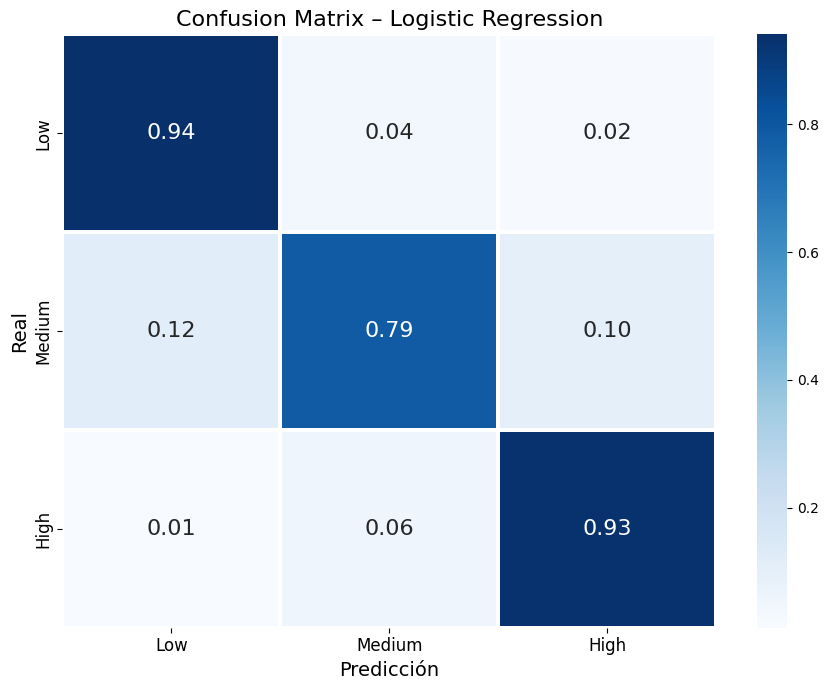

In [ ]:
class_names = ["Low", "Medium", "High"]

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(9, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 16},
    linewidths=1.5,
    linecolor="white"
)

plt.xlabel("Predicción", fontsize=14)
plt.ylabel("Real", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Confusion Matrix – Logistic Regression", fontsize=16)
plt.tight_layout()
plt.show()
